<h1>This is the code for COM3013 Coursework</h1>
<h2>Mofe Awosanya, Ebose Odijie, Hishaam Khan</h2>

These are all the imports

In [56]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Optimizer

Check if machine is using CUDA GPU

In [58]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cpu


We are using pytorch here to get the CIFAR10 dataset and set the classes.

In [57]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


KeyboardInterrupt: 

Let's see some of the images

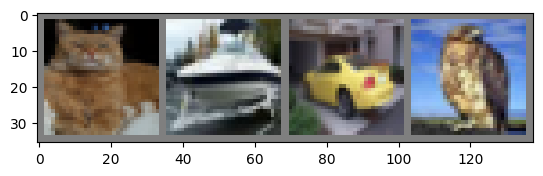

cat   ship  car   bird 


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Now to create the forward Neural Network

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = Model()

Now to define the Loss Function

In [ ]:
criterion = nn.CrossEntropyLoss()

Now to Define the Optimisation Function for the majority of the layers, for the final layer we will be using our own.

In [ ]:
default_optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Now to create our own Optimiser

In [ ]:
class MyOptimizer(Optimizer):
    def __init__(self, params, lr=0.001, beta=0.9):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if beta < 0.0 or beta >= 1.0:
            raise ValueError("Invalid beta value: {}".format(beta))

        defaults = dict(lr=lr, beta=beta)
        super(MyOptimizer, self).__init__(params, defaults)

    def step(self, closure=None):
        #This is where we will perform a single step for our optimisation algorithm
        loss=None
        return loss

In [ ]:
our_optimizer = MyOptimizer(model.parameters(), lr=0.01, beta=0.9)

Now to train our model

In [ ]:
for epoch in range(2):
    running_loss=0.0
    for i, data in enumerate(trainloader, 0):
        if device == 'cpu':
            inputs, labels = data
        else:
            inputs, labels = data[0].to(device), data[1].to(device)
        
        default_optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        default_optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.222
[1,  4000] loss: 1.899
[1,  6000] loss: 1.687
[1,  8000] loss: 1.582


KeyboardInterrupt: 

Save the Model

In [ ]:
PATH = './cifar_model.pth'
torch.save(model.state_dict(), PATH)

lets look at some of the testing images

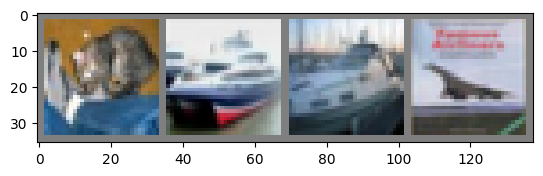

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4))) 

Now to evaluate the model using the testing batch

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        if device == 'cpu':
            inputs, labels = data
        else:
            inputs, labels = data[0].to(device), data[1].to(device) 
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Model Accuracy on Testing Images: {100 * correct // total} %')